# Deep Reinforcement Learning - Assignment 1
## Training and Testing DQN Agents on CartPole-v1

This notebook implements and evaluates Deep Q-Learning agents as specified in the assignment requirements.

### Assignment Structure:
- **Section 1**: Q-Learning Agent (Tabular)
- **Section 2**: Deep Q-Learning Agent (DQN) - Basic Implementation
- **Section 3**: Improved Deep Q-Learning Agent (Double DQN + Dueling Architecture)

---

## Setup and Imports

Import necessary libraries and modules.

In [38]:
# Setup: Add project root to Python path
import os
import sys

# Get the notebook's directory
notebook_dir = os.path.abspath('')
project_root = notebook_dir  # Since notebook is in project root

# Add to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Python path updated: {project_root in sys.path}")

Project root: c:\Users\yonat\CodeProjects\DRL\Assignment1
Python path updated: True


In [39]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, List
from datetime import datetime

# Gymnasium for CartPole environment
import gymnasium as gym

# PyTorch
import torch

# Disable PyTorch 2.0+ compilation features that might cause issues
torch._dynamo.config.suppress_errors = True
import torch._dynamo
torch._dynamo.disable()

# Force complete module reload - clear ALL cached imports
import sys
# Remove any agent-related modules
modules_to_remove = [key for key in list(sys.modules.keys()) 
                    if 'agent' in key.lower() or 'src' in key or 'utils' in key or 'ffnn' in key]
for module in modules_to_remove:
    del sys.modules[module]
    print(f"Removed cached module: {module}")

# NOW import our custom agents from src module
from src import (
    QLearningAgent,
    DeepQLearningAgent,
    ImprovedDeepQLearningAgent
)

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")

# Verify we're using the correct module
print(f"\nAgent module location: {DeepQLearningAgent.__module__}")

Removed cached module: src.utils
Removed cached module: src.ffnn
Removed cached module: src.agent
Removed cached module: src
✓ All imports successful!
PyTorch version: 2.9.0+cpu
Gymnasium version: 1.2.2

Agent module location: src.agent


## Helper Functions

Utility functions for visualization and analysis.

In [40]:
def plot_training_metrics(results: Dict[str, Any], agent_name: str, save_path: str = None):
    """
    Plot training metrics: rewards and losses.
    
    Args:
        results: Dictionary containing 'rewards', 'lengths', 'losses'
        agent_name: Name of the agent for plot title
        save_path: Optional path to save the figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Episode Rewards
    episodes = np.arange(1, len(results['rewards']) + 1)
    rewards = results['rewards']
    
    axes[0].plot(episodes, rewards, alpha=0.6, linewidth=0.8, label='Episode Reward')
    
    # Add moving average
    window = 100
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0].plot(np.arange(window, len(rewards) + 1), moving_avg, 
                    color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
        
        # Add horizontal line at 475 (target)
        axes[0].axhline(y=475, color='green', linestyle='--', linewidth=2, 
                       label='Target (475.0)', alpha=0.7)
    
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title(f'{agent_name}: Episode Rewards During Training')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Training Loss
    if results['losses']:
        training_steps = np.arange(1, len(results['losses']) + 1)
        losses = results['losses']
        
        axes[1].plot(training_steps, losses, alpha=0.6, linewidth=0.8, color='orange')
        
        # Add moving average for loss
        if len(losses) >= window:
            loss_moving_avg = np.convolve(losses, np.ones(window)/window, mode='valid')
            axes[1].plot(np.arange(window, len(losses) + 1), loss_moving_avg, 
                        color='red', linewidth=2, label=f'{window}-Step Moving Avg')
        
        axes[1].set_xlabel('Training Step')
        axes[1].set_ylabel('Loss')
        axes[1].set_title(f'{agent_name}: Training Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No loss data available', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title(f'{agent_name}: Training Loss')
    
    plt.tight_layout()
    
    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()


def find_convergence_episode(rewards: List[float], target: float = 475.0, window: int = 100) -> int:
    """
    Find the first episode where the agent achieves target average reward.
    
    Args:
        rewards: List of episode rewards
        target: Target average reward (default: 475.0)
        window: Window size for computing average (default: 100)
    
    Returns:
        Episode number (1-indexed) or -1 if target not reached
    """
    if len(rewards) < window:
        return -1
    
    for i in range(window - 1, len(rewards)):
        avg_reward = np.mean(rewards[i - window + 1:i + 1])
        if avg_reward >= target:
            return i + 1  # Return 1-indexed episode number
    
    return -1


def print_convergence_info(results: Dict[str, Any], agent_name: str):
    """Print convergence information."""
    convergence_ep = find_convergence_episode(results['rewards'])
    
    print(f"\n{'='*60}")
    print(f"CONVERGENCE ANALYSIS: {agent_name}")
    print(f"{'='*60}")
    
    if convergence_ep > 0:
        print(f"✓ Agent converged at episode: {convergence_ep}")
        print(f"  (First episode where 100-episode average ≥ 475.0)")
        
        # Show final performance
        final_100_avg = np.mean(results['rewards'][-100:])
        print(f"\nFinal Performance (last 100 episodes):")
        print(f"  Average Reward: {final_100_avg:.2f}")
        print(f"  Max Reward: {np.max(results['rewards'][-100:]):.2f}")
        print(f"  Min Reward: {np.min(results['rewards'][-100:]):.2f}")
    else:
        print(f"✗ Agent did not converge to 475.0 average within training")
        if len(results['rewards']) >= 100:
            best_100_avg = max([np.mean(results['rewards'][i:i+100]) 
                               for i in range(len(results['rewards']) - 99)])
            print(f"  Best 100-episode average achieved: {best_100_avg:.2f}")
    
    print(f"{'='*60}\n")


def save_model_and_results(agent, results: Dict[str, Any], agent_name: str, base_dir: str = "models"):
    """Save trained model and results."""
    os.makedirs(base_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model
    model_path = os.path.join(base_dir, f"{agent_name}_{timestamp}.pth")
    agent.save(model_path)
    
    # Save results
    results_path = os.path.join(base_dir, f"{agent_name}_{timestamp}_results.npz")
    np.savez(results_path, 
             rewards=results['rewards'],
             lengths=results['lengths'],
             losses=results['losses'])
    
    print(f"✓ Model saved to: {model_path}")
    print(f"✓ Results saved to: {results_path}")

---
# Section 2: Deep Q-Learning Agent (DQN)

In this section, we implement and train a basic DQN agent on CartPole-v1.

## Requirements:
- Neural network with configurable architecture (test 3 and 5 hidden layers)
- Experience replay buffer
- Target network for stability
- Epsilon-greedy exploration

## Analysis Tasks:
1. Find the number of episodes until average reward ≥ 475.0 over 100 consecutive episodes
2. Plot training loss at each step
3. Plot total reward per episode during training

## 2.1: Environment Setup

Create the CartPole-v1 environment.

In [41]:
# Create CartPole environment
env = gym.make('CartPole-v1')

# Get environment dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("CartPole-v1 Environment:")
print(f"  State dimension: {state_dim}")
print(f"  Action dimension: {action_dim}")
print(f"  State space: {env.observation_space}")
print(f"  Action space: {env.action_space}")
print("\nGoal: Keep pole balanced for as long as possible (max 500 steps)")

CartPole-v1 Environment:
  State dimension: 4
  Action dimension: 2
  State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  Action space: Discrete(2)

Goal: Keep pole balanced for as long as possible (max 500 steps)


## 2.2: Configure DQN Agent - 3 Hidden Layers

First, we'll train a DQN agent with **3 hidden layers** of size [64, 64, 64].

In [44]:
# Configuration for DQN with 3 hidden layers - STABLE CONFIG
config_3_layers = {
    'hidden_dims': [32, 32, 32],
    'learning_rate': 0.0005,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995,
    'batch_size': 64,
    'buffer_capacity': 10000,
    'target_update_freq': 50
}

# Create agent
agent_dqn_3layers = DeepQLearningAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    config=config_3_layers
)

print("DQN Agent Configuration (3 Hidden Layers):")
print(f"  Architecture: {config_3_layers['hidden_dims']}")
print(f"  Learning Rate: {config_3_layers['learning_rate']}")
print(f"  Discount Factor (γ): {config_3_layers['gamma']}")
print(f"  Epsilon Decay: {config_3_layers['epsilon_decay']}")
print(f"  Batch Size: {config_3_layers['batch_size']}")
print(f"  Replay Buffer Size: {config_3_layers['buffer_capacity']}")
print(f"  Target Update Frequency: {config_3_layers['target_update_freq']} steps")

Initialized DQN with 3 hidden layers: [32, 32, 32]
DQN Agent Configuration (3 Hidden Layers):
  Architecture: [32, 32, 32]
  Learning Rate: 0.0005
  Discount Factor (γ): 0.99
  Epsilon Decay: 0.995
  Batch Size: 64
  Replay Buffer Size: 10000
  Target Update Frequency: 50 steps


## 2.3: Train DQN Agent (3 Hidden Layers)

Train the agent for sufficient episodes to reach convergence.

In [ ]:
# Training parameters with early stopping
MAX_STEPS = 500
EVAL_FREQUENCY = 50
TARGET_REWARD = 475.0
TARGET_WINDOW = 100
MAX_EPISODES = 10000  # Safety limit

print("Starting training with early stopping...")
print(f"Max episodes: {MAX_EPISODES} (will stop early if target reached)")
print(f"Target: {TARGET_REWARD} average reward over {TARGET_WINDOW} episodes")
print(f"Max steps per episode: {MAX_STEPS}")
print(f"Evaluation frequency: every {EVAL_FREQUENCY} episodes\n")

# Train the agent with early stopping
results_3layers = agent_dqn_3layers.train_agent(
    env=env,
    max_episodes=MAX_EPISODES,
    max_steps=MAX_STEPS,
    eval_frequency=EVAL_FREQUENCY,
    target_reward=TARGET_REWARD,
    target_window=TARGET_WINDOW,
    verbose=True
)

print("\n✓ Training completed!")
print(f"Episodes trained: {results_3layers['episodes_trained']}")
print(f"Converged: {'Yes ✓' if results_3layers['converged'] else 'No ✗'}")

Starting training with early stopping...
Max episodes: 10000 (will stop early if target reached)
Target: 475.0 average reward over 100 episodes
Max steps per episode: 500
Evaluation frequency: every 50 episodes

Episode 50/10000 | Avg Reward (=Length): 22.24 | Epsilon: 0.778
Episode 50/10000 | Avg Reward (=Length): 22.24 | Epsilon: 0.778
Episode 100/10000 | Avg Reward (=Length): 48.46 | Epsilon: 0.606
Episode 100/10000 | Avg Reward (=Length): 48.46 | Epsilon: 0.606
Episode 150/10000 | Avg Reward (=Length): 89.36 | Epsilon: 0.471
Episode 150/10000 | Avg Reward (=Length): 89.36 | Epsilon: 0.471
Episode 200/10000 | Avg Reward (=Length): 159.92 | Epsilon: 0.367
Episode 200/10000 | Avg Reward (=Length): 159.92 | Epsilon: 0.367
Episode 250/10000 | Avg Reward (=Length): 189.96 | Epsilon: 0.286
Episode 250/10000 | Avg Reward (=Length): 189.96 | Epsilon: 0.286
Episode 300/10000 | Avg Reward (=Length): 166.80 | Epsilon: 0.222
Episode 300/10000 | Avg Reward (=Length): 166.80 | Epsilon: 0.222
Epis

## 2.4: Analyze Training Results (3 Hidden Layers)

Analyze convergence and plot training metrics.


CONVERGENCE ANALYSIS: DQN (3 Hidden Layers)
✗ Agent did not converge to 475.0 average within training
  Best 100-episode average achieved: 383.39

Figure saved to results/section2/dqn_3layers_training.png
Figure saved to results/section2/dqn_3layers_training.png


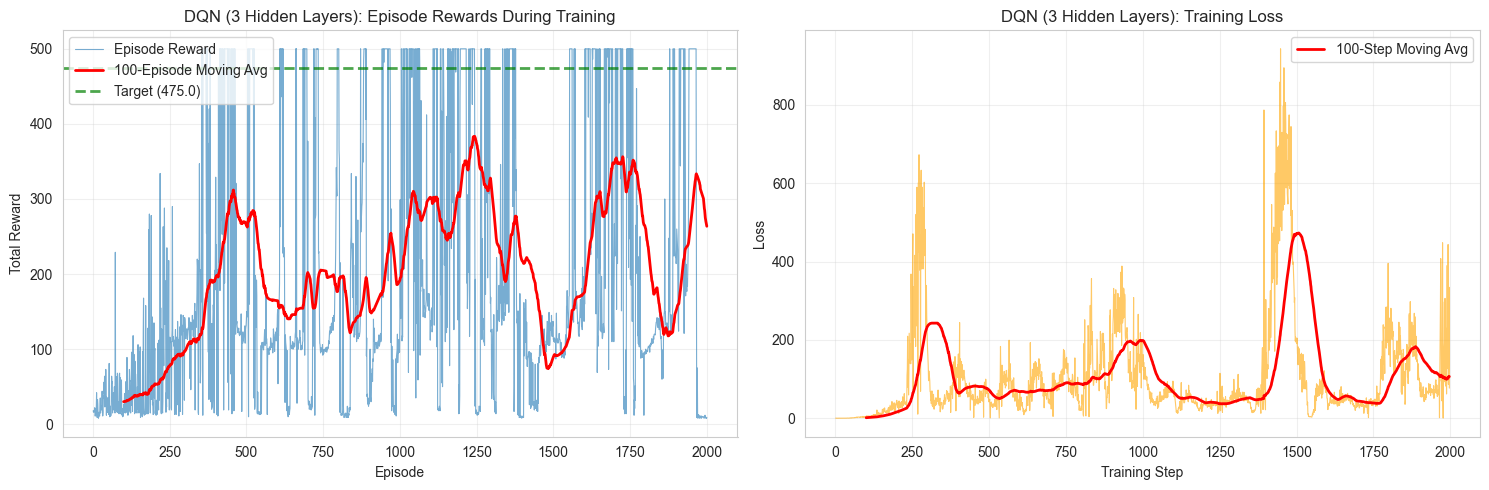

In [ ]:
# Print convergence information
print_convergence_info(results_3layers, "DQN (3 Hidden Layers)")

# Plot training metrics
plot_training_metrics(
    results_3layers, 
    "DQN (3 Hidden Layers)",
    save_path="results/section2/dqn_3layers_training.png"
)

## 2.5: Test DQN Agent (3 Hidden Layers)

Test the trained agent on new episodes.

In [ ]:
# Test the agent
print("Testing trained agent...")
mean_reward, std_reward = agent_dqn_3layers.test_agent(
    env=env,
    num_episodes=10,
    render=False,
    max_steps=500
)

Testing trained agent...

Testing agent for 10 episodes...

Test Results:
Mean Reward: 500.00 ± 0.00
Mean Episode Length: 500.00


## 2.6: Save Model and Results (3 Hidden Layers)

In [ ]:
# Save the trained model and results
save_model_and_results(
    agent_dqn_3layers,
    results_3layers,
    "dqn_3layers"
)

Model saved to models\dqn_3layers_20251115_184959.pth
✓ Model saved to: models\dqn_3layers_20251115_184959.pth
✓ Results saved to: models\dqn_3layers_20251115_184959_results.npz


## 2.7: Configure DQN Agent - 5 Hidden Layers

Now, we'll train a DQN agent with **5 hidden layers** of size [64, 64, 64, 64, 64].

In [ ]:
# Configuration for DQN with 5 hidden layers - STABLE CONFIG
config_5_layers = {
    'hidden_dims': [32, 32, 32, 32, 32],
    'learning_rate': 0.0005,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995,
    'batch_size': 64,
    'buffer_capacity': 10000,
    'target_update_freq': 50
}

# Create agent
agent_dqn_5layers = DeepQLearningAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    config=config_5_layers
)

print("DQN Agent Configuration (5 Hidden Layers):")
print(f"  Architecture: {config_5_layers['hidden_dims']}")
print(f"  Learning Rate: {config_5_layers['learning_rate']}")
print(f"  Discount Factor (γ): {config_5_layers['gamma']}")
print(f"  Epsilon Decay: {config_5_layers['epsilon_decay']}")
print(f"  Batch Size: {config_5_layers['batch_size']}")
print(f"  Replay Buffer Size: {config_5_layers['buffer_capacity']}")
print(f"  Target Update Frequency: {config_5_layers['target_update_freq']} steps")

## 2.8: Train DQN Agent (5 Hidden Layers)

In [ ]:
print("Starting training with early stopping...")
print(f"Max episodes: {MAX_EPISODES} (will stop early if target reached)")
print(f"Target: {TARGET_REWARD} average reward over {TARGET_WINDOW} episodes")
print(f"Max steps per episode: {MAX_STEPS}")
print(f"Evaluation frequency: every {EVAL_FREQUENCY} episodes\n")

# Train the agent with early stopping
results_5layers = agent_dqn_5layers.train_agent(
    env=env,
    max_episodes=MAX_EPISODES,
    max_steps=MAX_STEPS,
    eval_frequency=EVAL_FREQUENCY,
    target_reward=TARGET_REWARD,
    target_window=TARGET_WINDOW,
    verbose=True
)

print("\n✓ Training completed!")
print(f"Episodes trained: {results_5layers['episodes_trained']}")
print(f"Converged: {'Yes ✓' if results_5layers['converged'] else 'No ✗'}")

## 2.9: Analyze Training Results (5 Hidden Layers)

In [ ]:
# Print convergence information
print_convergence_info(results_5layers, "DQN (5 Hidden Layers)")

# Plot training metrics
plot_training_metrics(
    results_5layers, 
    "DQN (5 Hidden Layers)",
    save_path="plots/dqn_5layers_training.png"
)

## 2.10: Test DQN Agent (5 Hidden Layers)

In [ ]:
# Test the agent
print("Testing trained agent...")
mean_reward, std_reward = agent_dqn_5layers.test_agent(
    env=env,
    num_episodes=10,
    render=False,
    max_steps=500
)

## 2.11: Save Model and Results (5 Hidden Layers)

In [ ]:
# Save the trained model and results
save_model_and_results(
    agent_dqn_5layers,
    results_5layers,
    "dqn_5layers"
)

## 2.12: Compare 3-Layer vs 5-Layer Architectures

Compare the performance of both network architectures.

In [ ]:
# Comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

window = 100

# Plot 1: Rewards comparison
for results, label, color in [(results_3layers, '3 Hidden Layers', 'blue'),
                               (results_5layers, '5 Hidden Layers', 'orange')]:
    episodes = np.arange(1, len(results['rewards']) + 1)
    
    # Moving average
    if len(results['rewards']) >= window:
        moving_avg = np.convolve(results['rewards'], np.ones(window)/window, mode='valid')
        axes[0].plot(np.arange(window, len(results['rewards']) + 1), moving_avg,
                    linewidth=2, label=label, color=color)

axes[0].axhline(y=475, color='green', linestyle='--', linewidth=2, 
               label='Target (475.0)', alpha=0.7)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Average Reward (100-episode window)')
axes[0].set_title('DQN Architecture Comparison: Rewards')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss comparison
for results, label, color in [(results_3layers, '3 Hidden Layers', 'blue'),
                               (results_5layers, '5 Hidden Layers', 'orange')]:
    if len(results['losses']) >= window:
        loss_moving_avg = np.convolve(results['losses'], np.ones(window)/window, mode='valid')
        axes[1].plot(np.arange(window, len(results['losses']) + 1), loss_moving_avg,
                    linewidth=2, label=label, color=color)

axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Average Loss (100-step window)')
axes[1].set_title('DQN Architecture Comparison: Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/dqn_architecture_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Print comparison summary
print("\n" + "="*60)
print("ARCHITECTURE COMPARISON SUMMARY")
print("="*60)

conv_3 = find_convergence_episode(results_3layers['rewards'])
conv_5 = find_convergence_episode(results_5layers['rewards'])

print(f"\n3 Hidden Layers:")
print(f"  Convergence episode: {conv_3 if conv_3 > 0 else 'Not achieved'}")
print(f"  Final 100-ep avg: {np.mean(results_3layers['rewards'][-100:]):.2f}")

print(f"\n5 Hidden Layers:")
print(f"  Convergence episode: {conv_5 if conv_5 > 0 else 'Not achieved'}")
print(f"  Final 100-ep avg: {np.mean(results_5layers['rewards'][-100:]):.2f}")

print("\n" + "="*60)

## 2.13: Summary and Answers

### Assignment Questions - Section 2:

**Q1: Number of episodes until the agent obtains an average reward of at least 475.0 over 100 consecutive episodes**

See the convergence analysis above for both architectures.

**Q2: Plot of the loss in each training step**

See the loss plots in the training metrics above (right panels).

**Q3: Plot of the total reward of each episode in training**

See the reward plots in the training metrics above (left panels).

### Key Observations:
- The DQN algorithm successfully learns to balance the CartPole
- Experience replay and target networks provide stable learning
- Both architectures should converge, though convergence speed may differ
- The 3-layer architecture may converge faster due to fewer parameters

---
# Next Steps

To complete the full assignment:

1. **Section 1**: Implement Q-Learning with discretization (for reference/comparison)
2. **Section 3**: Implement Improved DQN (Double DQN + Dueling architecture)
3. **Hyperparameter tuning**: Experiment with learning rates, batch sizes, etc.
4. **Analysis**: Compare all approaches and answer theoretical questions

Run this notebook to train and evaluate the basic DQN agent!

In [ ]:
# Clean up
env.close()
print("Environment closed. Notebook execution complete!")

In [ ]:
# Diagnostic: Check if we're importing correctly
import sys
print("Modules loaded:")
for key in list(sys.modules.keys()):
    if 'agent' in key.lower() or 'src' in key.lower():
        print(f"  {key}")

In [ ]:
# Workaround for PyTorch DispatchKey issue
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['TORCH_DYNAMO_DISABLE'] = '1'

# Disable torch compile to avoid dispatch key issues
import torch
torch._dynamo.config.suppress_errors = True

In [ ]:
# Create necessary directories
import os
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)
print("✓ Created plots and models directories")